In [1]:
%matplotlib inline

In [2]:
# Dependencies and Setup
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress
import statsmodels.formula.api as smf
from empiricaldist import Pmf
import time

# record time before execution
start_time = time.time()

# Data Preparation

In [3]:
# File to Load (Remember to Change These)
file_to_load = "Resources/purchase_data.csv"

# Read Purchasing File and store into Pandas data frame
purchase_data = pd.read_csv(file_to_load)

# Creating functions for dataset analysis
purchase_data['Purchase ID']= 'Heroes_of_Pymoli'
tot_players = purchase_data['SN'].nunique()
def len_unique (x):
    return len(x.unique())
def percentage (x):
    return len_unique(x)/tot_players*100
def analysis (x):
    df_analysis = purchase_data.groupby(x).agg(Number_of_Players = ("SN", len_unique), 
                                                        Percent_of_Players = ("SN", percentage), 
                                                        Number_of_Unique_Items = ("Item Name", len_unique),
                                                        Average_Price_USD = ("Price", 'mean'), 
                                                        Number_of_Purchases = ("Price", 'count'), 
                                                        Purchase_Value_USD = ("Price", 'sum'))
    df_analysis['Purchase_Value_per_Person'] = df_analysis['Purchase_Value_USD']/df_analysis['Number_of_Players']
    return df_analysis

pd.options.display.float_format = '{:,.2f}'.format

## Total Purchasing Analysis

In [4]:
analysis('Purchase ID')

,Number_of_Players,Percent_of_Players,Number_of_Unique_Items,Average_Price_USD,Number_of_Purchases,Purchase_Value_USD,Purchase_Value_per_Person
Purchase ID,,,,,,,
Heroes_of_Pymoli,576,100.00,179,3.05,780,"2,379.77",4.13


## Gender Demographics and Purchasing Analysis by Gender

In [5]:
analysis('Gender')

,Number_of_Players,Percent_of_Players,Number_of_Unique_Items,Average_Price_USD,Number_of_Purchases,Purchase_Value_USD,Purchase_Value_per_Person
Gender,,,,,,,
Female,81,14.06,90,3.20,113,361.94,4.47
Male,484,84.03,178,3.02,652,"1,967.64",4.07
Other / Non-Disclosed,11,1.91,13,3.35,15,50.19,4.56


## Age Demographics and Purchasing Analysis by Age

In [6]:
age_df = analysis('Age')

Text(0.5, 1.0, 'Number of players over age')

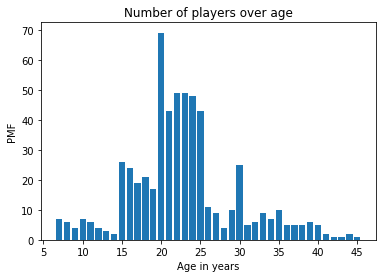

In [7]:
#Exploring DataSet with Probability Mass Function
num_players=age_df['Number_of_Players']
Pmf(num_players).bar()
plt.xlabel('Age in years')
plt.ylabel('PMF')
plt.title("Number of players over age")

In [8]:
age_df=age_df.reset_index()

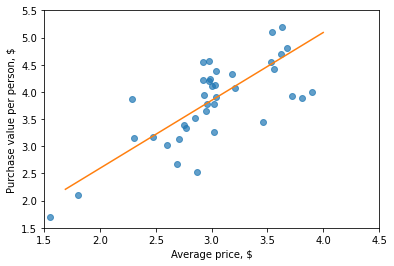

In [9]:
# Evaluating a linear relationship between Average price and Purchase value per person
# Extract data
data = age_df.dropna(subset=['Average_Price_USD', 'Purchase_Value_per_Person'])
xs = data['Average_Price_USD']
ys = data['Purchase_Value_per_Person']

# Compute the linear regression
res = linregress(xs, ys)

# Plot the scatter plot
plt.clf()
x_jitter = xs + np.random.normal(0, 0.15, len(xs))
plt.plot(x_jitter, ys, 'o', alpha=0.7)

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-', alpha=2)

plt.xlabel('Average price, $')
plt.ylabel('Purchase value per person, $')
plt.ylim([1.5, 5.5])
plt.xlim([1.5, 4.5])
plt.show()

In [10]:
#Binning
group_names = ["<10", "10-14", "15-19", "20-24","25-29","30-34","35-39","40+"]
bins = [0,10,15,20,25,30,35,40,46]
age_df["Age Ranges"] = pd.cut(age_df["Age"], bins=bins,right = False, labels=group_names)
age_sum_df = age_df.groupby("Age Ranges").agg(Purchase_Count = ('Number_of_Unique_Items', 'sum'),
                                          Average_Purchase_Price = ('Average_Price_USD','mean'), 
                                          Total_Purchase_Value =('Purchase_Value_USD', 'sum'),
                                          Avg_Total_Purchase_per_Person = ('Purchase_Value_per_Person', 'mean'))
age_sum_df

,Purchase_Count,Average_Purchase_Price,Total_Purchase_Value,Avg_Total_Purchase_per_Person
Age Ranges,,,,
<10,23,3.32,77.13,4.53
10-14,28,2.93,82.78,3.65
15-19,127,3.03,412.89,3.85
20-24,306,3.04,"1,114.06",4.30
25-29,91,2.62,293.00,3.31
30-34,72,2.87,214.00,4.01
35-39,40,3.51,147.67,4.71
40+,13,3.06,38.24,3.15


### Simple Prediction Model
* Dependent variable: Purchase_Value
* Independent variables: Age, Number of Players

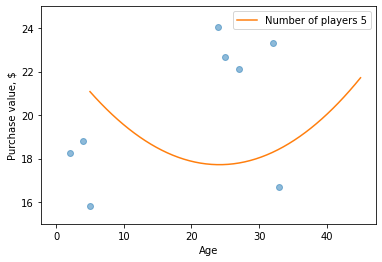

In [11]:
# Extract the actual data
real_purchase = age_df['Purchase_Value_USD']
age_df['Age_2']= age_df['Age']**2
age_df['Number_of_Players_2']= age_df['Number_of_Players']**2 
results = smf.ols('real_purchase ~ Age + Age_2 + Number_of_Players + Number_of_Players_2', data=age_df).fit()

# Make the Prediction DataSet
predict_df = pd.DataFrame()
predict_df['Age'] = np.linspace(5, 45)
predict_df['Number_of_Players'] = 5
predict_df['Number_of_Players_2'] = predict_df['Number_of_Players']**2
predict_df['Age_2'] = predict_df['Age']**2

# Plot mean Purchase value in each age group
plt.clf()
plt.plot(real_purchase,'o', alpha=0.5)

# Generate and plot the predictions
pred = results.predict(predict_df)
plt.plot(predict_df['Age'], pred, label='Number of players 5')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Purchase value, $')
plt.ylim([15, 25])
# plt.xlim([0, 40])
plt.show()

## Top Spenders

In [12]:
spending_df = analysis('SN').filter(['Number_of_Purchases', 'Average_Price_USD', 'Purchase_Value_USD'])
spending_df.sort_values('Purchase_Value_USD', ascending=False).head()

,Number_of_Purchases,Average_Price_USD,Purchase_Value_USD
SN,,,
Lisosia93,5,3.79,18.96
Idastidru52,4,3.86,15.45
Chamjask73,3,4.61,13.83
Iral74,4,3.40,13.62
Iskadarya95,3,4.37,13.10


## Most Popular Items

In [13]:
popular_df = purchase_data.filter(['Item ID', 'Item Name', 'Price'])
popular_df = popular_df.groupby(['Item ID', 'Item Name']).agg(Purchase_Count=('Price', 'count'),
                                                              Item_Price = ("Price", 'mean'),
                                                             Total_Purchase_Value=('Price', 'sum'))
popular_df.sort_values('Purchase_Count', ascending=False).head()

,,Purchase_Count,Item_Price,Total_Purchase_Value
Item ID,Item Name,,,
92,Final Critic,13,4.61,59.99
178,"Oathbreaker, Last Hope of the Breaking Storm",12,4.23,50.76
145,Fiery Glass Crusader,9,4.58,41.22
132,Persuasion,9,3.22,28.99
108,"Extraction, Quickblade Of Trembling Hands",9,3.53,31.77


## Most Profitable Items

In [14]:
popular_df.sort_values('Total_Purchase_Value', ascending=False).head()

,,Purchase_Count,Item_Price,Total_Purchase_Value
Item ID,Item Name,,,
92,Final Critic,13,4.61,59.99
178,"Oathbreaker, Last Hope of the Breaking Storm",12,4.23,50.76
82,Nirvana,9,4.90,44.10
145,Fiery Glass Crusader,9,4.58,41.22
103,Singed Scalpel,8,4.35,34.80


In [15]:
# record time after execution
end_time = time.time()
print("Result calculated in {:,.2f} sec".format(end_time - start_time))

Result calculated in 0.83 sec
